## Set Up

In [1]:
import os
import sys
#set custom path
sys.path.insert(0, os.path.abspath(r'\users\fynn\documents\anaconda\envs\tf_keras_gpu_test\lib\site-packages'))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from torchvision import datasets, transforms
import torch

from copy import deepcopy as dc
import random
from statistics import mean


from PIL import Image
import requests
from io import BytesIO

from recommend_images import *

## 1. Import existing

In [3]:
#code to try clustering subset of embeddings

#import embeddings of existing dir
#all_embeds = np.load('../features.npy')
#np.save('../image_dir/features.npy', all_embeds[:1000])

In [3]:
#pull in base embeds
base_embeds  = np.load('../image_dir/features.npy')


#load base images
data_dir = '../image_dir/samples'


tc = transforms.Compose([

        transforms.Resize((160, 240)),

        transforms.ToTensor()              

    ])

image_datasets = datasets.ImageFolder(data_dir, transform = tc)
dloader = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=False)
print(len(image_datasets)) #number of datapoints

10892


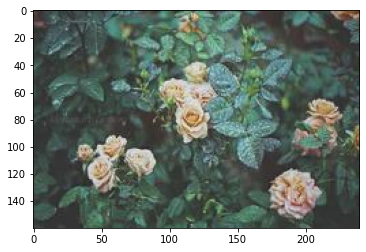

In [8]:
#test
file_keys = get_file_key('../image_dir/samples/pics')

plt.imshow((image_datasets[get_image('45', file_keys)][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))

## 1.5 Visualize Clusters

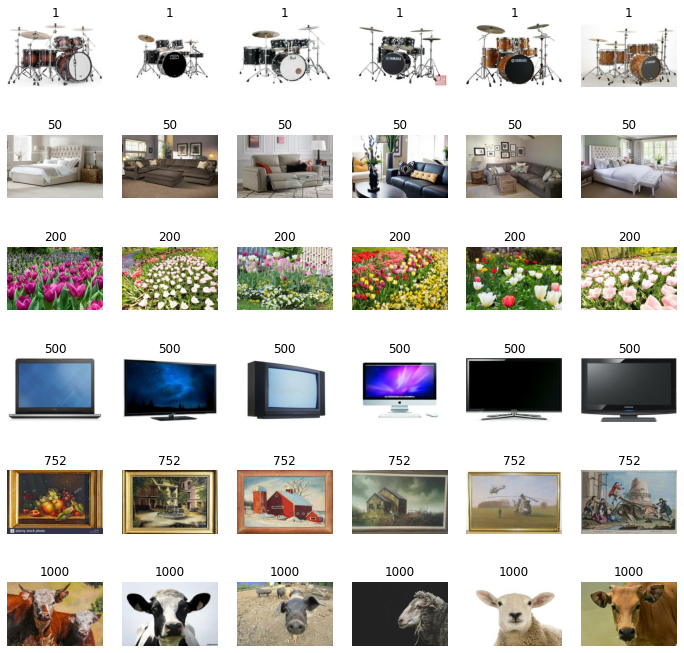

In [14]:
nrows =6
ncols = 6
cluster_choice = [1, 50, 200, 500, 752, 1000]

plt.figure(figsize=(12, 12))
position = 1
for i in range(nrows):
    cluster = cluster_choice[i]
    
    raw_ims = os.listdir(os.path.join('..\image_dir\clusters', str(cluster)))
    
    plot_indices = []
    for image in raw_ims:
        plot_indices.append(image.replace('.jpeg', ''))

    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow((image_datasets[get_image(plot_indices[j], file_keys)][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
        plt.title(cluster)      
    
        plt.axis("off")
        position += 1

plt.savefig('distribution_eval.jpeg')

## 2. Embed new image

In [8]:
%run distribution_clustering\save_dataset_features.py --data_dir C:\Users\fynn\Documents\Lighthouse_Labs\Final\test_dir

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


In [9]:
#load test image embed
input_embed = np.load('../test_dir/features.npy')
print(input_embed.shape)

(1, 2048)


## 3. Find Duplicate

In [3]:
def get_distance(input_embed, comparison_embeds):
    import scipy.spatial

    #translate to same size array as base embeds
    input_expanded = np.repeat(input_embed, len(comparison_embeds), axis = 0)
    
    cluster_dist = scipy.spatial.distance.cdist(input_expanded, comparison_embeds, 'sqeuclidean')
    cluster_dist = cluster_dist[0]
    return cluster_dist

def image_duplicate(input_embed, embed_dir, image_dir, plot_dup_image = False):
    
    embed_distances = get_distance(input_embed, embed_dir)
    
    if min(embed_distances) == 0:
        print('Photo Exists')
        dup_idx = np.where(embed_distances == min(embed_distances))[0][0]
        
        if bool(plot_dup_image):
            plt.imshow((image_dir[dup_idx][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
            
    else:
        print('Photo does not exist yet')
        dup_idx = None
    
    return dup_idx
        

In [172]:
input_dist = get_distance(input_embed, base_embeds)

## 4. Recommend

In [11]:
def return_recommendation(input_distances, duplicate_idx, path, plot_similar = False):
    
    cluster_idx = np.load(os.path.join(path, 'cluster_idx.npy'))
    
    #is duplicate
    if duplicate_idx is not None:
        input_cluster = cluster_idx[dup_idx]
        #get file name of dup_idx
        dup_file = int(file_keys_df.iloc[dup_idx][0])
    
    #is not duplicate
    if duplicate_idx is None:
        anchor_idx = input_distances.argsort()[1]
        input_cluster = cluster_idx[anchor_idx]
        dup_file = None
        print(input_cluster)
    #list images from within cluster
    similar_imgs = os.listdir(os.path.join(path, 'clusters', str(input_cluster)))
    
    #turn into int
    similar_idx = []
    for image in similar_imgs:
        temp_idx = int(str(image).replace('.jpeg', ''))
        #if not duplicate file
        if temp_idx != dup_file:
            similar_idx.append(temp_idx)
    
    #if plot is true plot similar images
    if bool(plot_similar):
        fig, axes = plt.subplots(1, 4, figsize = (10, 2))
        
        for i, ax in enumerate(axes.flat):
            ax.imshow((image_datasets[get_image(str(similar_idx[i]))][0].detach().numpy().transpose(1, 2, 0)* 255).astype(np.uint8))


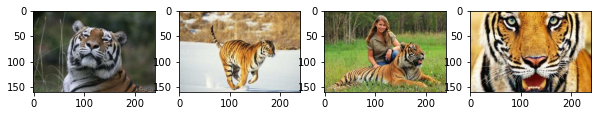

In [12]:
return_recommendation(input_dist, dup_idx, '../image_dir', plot_similar = True)

### Test on original image

In [14]:
sys.path.insert(0, os.path.abspath(r'\users\fynn\documents\Lighthouse_Labs\Final\distribution_clustering'))


%run ..\distribution_clustering\save_dataset_features.py --data_dir C:\Users\fynn\Documents\Lighthouse_Labs\Final\test2_dir

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


In [13]:
unique_embed = np.load('../test2_dir/features.npy')

unique_distances = get_distance(unique_embed)
_ = image_duplicate(unique_distances, plot_dup_image= True)

Photo does not exist yet


859


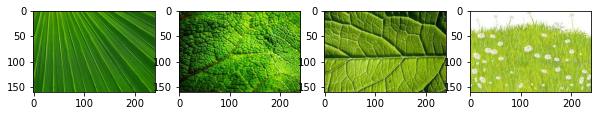

In [14]:
return_recommendation(unique_distances, None, '../image_dir', plot_similar = True)

## 4.5 Sample Testing

In [22]:
#cluster 
#%run ..\distribution_clustering\cluster_dataset.py --data_dir C:\Users\fynn\Documents\Lighthouse_Labs\Final\sample_dir

In [12]:
#pull in test embeds
test_embeds  = np.load('../sample_dir/features.npy')
test_centers = np.load('../sample_dir/centers.npy')

#load test images
test_dir = '../sample_dir/samples'


tc = transforms.Compose([

        transforms.Resize((160, 240)),

        transforms.ToTensor()              

    ])

test_dataset = datasets.ImageFolder(test_dir, transform = tc)
dloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
print(len(test_dataset)) #number of datapoints

500


In [32]:
input_expanded = np.repeat(input_embed, len(test_centers), axis = 0)
input_expanded.shape

(51, 2048)

In [46]:
#get distances between input image and every test image
import scipy.spatial

center_dist = scipy.spatial.distance.cdist(input_expanded, test_centers, 'sqeuclidean')
#add one because cluster names start at 1
input_cluster = center_dist[0].argsort()[0] + 1
print(input_cluster)

44


In [117]:
#load file keys for sample directory
temp_file_keys = get_file_key('../sample_dir/samples/pics')
get_image('5', temp_file_keys)

445

Photo exists


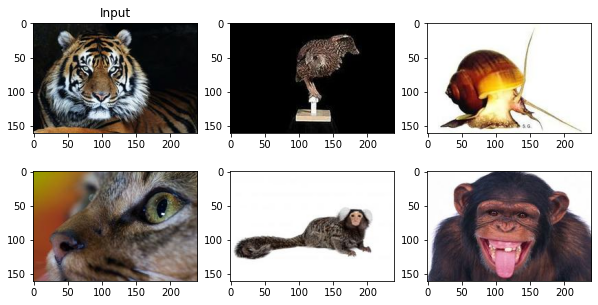

In [170]:
return_recommendation_test('../test_dir', '../sample_dir', plot_similar = True)

In [1]:
return_recommendation_test('../test_dir', '../image_dir', plot_similar = True)

NameError: name 'return_recommendation_test' is not defined